## Running MOVE and analyze the latent space

This notebook runs part of the Multi-Omics Variational autoEncoder (MOVE) framework for training the model for integrating the data into the latent space, plotting the results and analyse the important variables for the integration- Before running this code the optimal hyperparameters need to be identified as described in the notebookes <i>MOVE_hyperparameter_optimization_reconstruction.ipynb</i> and <i>MOVE_hyperparameter_optimization_stability.ipynb</i>.

In [1]:
# !pip install statsmodels

In [137]:
# Load functions
from scipy.stats.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
from collections import defaultdict
import scipy
from scipy import stats
from statsmodels.stats.multitest import multipletests
from functools import reduce
import umap

import matplotlib
import matplotlib.pyplot as plt
import random
import copy
import scipy
from scipy import stats
matplotlib.use('agg')
plt.style.use('seaborn-whitegrid')

import warnings
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator

import os, sys
import torch
import numpy as np
from torch.utils import data
import re 

from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
from utils.data_utils import *
import plot_importance
from tqdm import tqdm

In [3]:
# Functions for plotting

def embedding_plot_discrete(embedding, _type, name, file, palette=None):
   fig = plt.figure(figsize=(12,8))
   if palette == None:
      palette = sns.color_palette('colorblind', len(np.unique(_type)))
   
   ax = sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=_type,
                        palette = palette,
                        linewidth=0.1, alpha = 0.8, s=40, edgecolor = 'black')
                        
   
   box = ax.get_position()
   ax.set_position([box.x0, box.y0, box.width * 0.80, box.height]) # resize position
   
   legend_format = {name: np.unique(_type)}
   leg = subtitle_legend(ax, legend_format=legend_format)
   
   plt.xlabel('Dim1')
   plt.ylabel('Dim2')
   plt.style.use('default')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.spines['left'].set_visible(True)
   ax.spines['bottom'].set_visible(True)
   
   plt.savefig(file)

    
    
def embedding_plot_float(embedding, type, name, file):
   fig, ax = plt.subplots(figsize=(12,8))
   points = ax.scatter(x=embedding[:,0], y=embedding[:,1], c=type, s=40, cmap="Spectral_r",
                       edgecolor = 'black', linewidth=0.1)
   
   cbar = fig.colorbar(points, fraction=0.03, pad=0.03)
   cbar.ax.set_title(name, rotation=0, fontsize = 16)
   
   box = ax.get_position()
   ax.set_position([box.x0, box.y0, box.width * 0.90, box.height])
   
   plt.xlabel('Dim1')
   plt.ylabel('Dim2')
   plt.style.use('default')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.spines['left'].set_visible(True)
   ax.spines['bottom'].set_visible(True)
   
   plt.savefig(file)


def subtitle_legend(ax, legend_format):
   new_handles = []
   
   handles, labels = ax.get_legend_handles_labels()
   label_dict = dict(zip(labels, handles))
   
   #Means 2 labels were the same
   if len(label_dict) != len(labels):
       raise ValueError("Can not have repeated levels in labels!")
     
   for subtitle, level_order in legend_format.items():
       #Roll a blank handle to add in the subtitle
       blank_handle = matplotlib.patches.Patch(visible=False, label=subtitle)
       new_handles.append(blank_handle)
       
       for level in level_order:
           handle = label_dict[str(level)]
           new_handles.append(handle)
   
   #Labels are populated from handle.get_label() when we only supply handles as an arg
   legend = ax.legend(handles=new_handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                  fontsize = 14)
   #Turn off DrawingArea visibility to left justify the text if it contains a subtitle
   for draw_area in legend.findobj(matplotlib.offsetbox.DrawingArea):
       for handle in draw_area.get_children():
           if handle.get_label() in legend_format:
               draw_area.set_visible(False)
   
   return legend


In [5]:
# Load MOVE specific funtions and SHAP analysis
path = "./"
sys.path.append(path + "src/")
import VAE_v2_1
import plot_importance

Read in the data processed by <i>encode_data.ipynb</i>

In [6]:
data_dict = read_yaml('data')
cat_list, con_list, cat_names, con_names, headers_all, drug, drug_h = get_data(data_dict)

Initialize varriables and make model using the identified optimal hyperparameters from the optimzsation steps. Here using equal weight for all continuous but double weight on the clinical data to ensure sufficient learning and focus of the structure of interested (Type 2 Dieabetes). 

In [7]:
# Set to True if training using a GPU
cuda = False

# Training parameters
nepochs=2 # Changed from nepochs=200
lrate=0.0001
kldsteps=[20, 30, 40]
batchsteps=[50, 100, 150, 200]
# optimizer = optim.Adam(model.parameters(), lr=lrate)

epochs = range(1, nepochs + 1)


#nepochs from earlier training

In [81]:
#Todos: upload nhiddens, nlatent, dropout comes from earlier notebook
def train_model(path, cuda, nepochs, kldsteps, lrate, con_list, cat_list):
    
    device = torch.device("cuda" if cuda == True else "cpu")
    
    # Making the dataloader
    mask, train_loader = VAE_v2_1.make_dataloader(cat_list=cat_list, con_list=con_list, batchsize=10) #Added drop_last

    # Get variabels needed to initialize the model
    ncontinuous = train_loader.dataset.con_all.shape[1]
    con_shapes = train_loader.dataset.con_shapes

    ncategorical = train_loader.dataset.cat_all.shape[1]
    cat_shapes = train_loader.dataset.cat_shapes
    
    # Make model
    model = VAE_v2_1.VAE(ncategorical=ncategorical, ncontinuous=ncontinuous, 
                         con_shapes=con_shapes, cat_shapes=cat_shapes,
                         nhiddens=[2000], nlatent=200, beta=0.0001, 
                         cat_weights=[1,1,1], con_weights=[2,1,1,1,1,1,1], 
                         dropout=0.2, cuda=cuda).to(device)
    
    kld_w = 0
    l = len(kldsteps)
    rate = 20/l
    update = 1 + rate
    
    # Lists for saving the results
    losses = list(); ce = list(); sse = list(); KLD = list()

    # Training the model
    for epoch in range(1, nepochs + 1):

        if epoch in kldsteps:
            kld_w = 1/20 * update
            update += r

        if epoch in batchsteps:
                train_loader = DataLoader(dataset=train_loader.dataset,
                                          batch_size=int(train_loader.batch_size * 1.25),
                                          shuffle=True,
                                          drop_last=False, #Added
                                          num_workers=train_loader.num_workers,
                                          pin_memory=train_loader.pin_memory)

        l, c, s, k = model.encoding(train_loader, epoch, lrate, kld_w)

        losses.append(l)
        ce.append(c)
        sse.append(s)
        KLD.append(k)

        best_model = copy.deepcopy(model)
    return(best_model, mask, train_loader, losses, ce, sse, KLD)
        
best_model, mask, train_loader, losses, ce, sse, KLD = train_model(path, cuda, nepochs, kldsteps, lrate, con_list, cat_list)

	Epoch: 1	Loss: 14.100737	CE: 3.6992307	SSE: 10.401506	KLD: 0.0000	Batchsize: 10
	Epoch: 2	Loss: 13.398485	CE: 3.6196792	SSE: 9.778805	KLD: 0.0000	Batchsize: 10


In [15]:
def visualize_training(losses, ce, sse, KLD, epochs):
    # Plot traing error
    fig = plt.figure()
    plt.plot(epochs, losses, '-g', label='loss')
    plt.plot(epochs, ce, '-b', label='CE')
    plt.plot(epochs, sse, '-r', label='SSE')
    plt.plot(epochs, KLD, '-y', label='KLD')
    plt.legend()
    plt.savefig(path + "loss_test.png")


In [16]:
def get_latents(train_loader, kld_w=1): #TODOs: get right train_loader; what is right kld_w? - change to 1 testi if it works
    
    # Extracting the latent space
    train_test_loader = DataLoader(dataset=train_loader.dataset, batch_size=1, 
                                   drop_last=False, shuffle=False, 
                                   pin_memory=train_loader.pin_memory) # removed num_workers=1,

    latent, latent_var, cat_recon, cat_class, \
    con_recon, loss, likelihood = best_model.latent(train_test_loader, kld_w=1)

    con_recon = np.array(con_recon)
    con_recon = torch.from_numpy(con_recon)
    
    return latent, latent_var, cat_recon, cat_class, con_recon, loss, likelihood


latent, latent_var, cat_recon, cat_class, con_recon, loss, likelihood = get_latents(train_loader, 1)

====> Test set loss: 12.4287


In [17]:
def calc_categorical_reconstruction_acc(cat_shapes, cat_class, can_recon, cat_recon_tmp):
   # Calculate the categorical reconstruction accuracy
   cat_true_recon = []
   cat_total_recon = []
   pos = 0
   for s in cat_shapes:
      n = s[1]
      cat_class_tmp = cat_class[:,pos:(n + pos)]
      cat_recon_tmp = cat_recon[:,pos:(n + pos)]

      missing_cat = cat_recon_tmp[cat_class_tmp == -1]
      diff_cat = cat_class_tmp - cat_recon_tmp

      diff_cat[diff_cat != 0] = -1
      true_cat = diff_cat[diff_cat == 0]
      false_cat = diff_cat[diff_cat != 0]
      cat_true = len(true_cat)/(float(diff_cat.size) - missing_cat.size)
      cat_true_recon.append(cat_true)
      diff_cat[diff_cat == 0] = 1
      diff_cat[diff_cat != 1] = 0
      cat_total_recon.append(np.count_nonzero(diff_cat, 1) / diff_cat.shape[1])
      pos += n
   return(cat_total_recon)
    

In [18]:
def calc_categorical_reconstruction_acc(con_shapes, con_recon, train_loader):
   # Calculate the continuous reconstruction accuracy
   total_shape = 0
   true_recon = []
   cos_values = []
   all_values = []
   for s in con_shapes:
      cor_con = list()
      cos_con = list()
      all_val = list()
      for n in range(0, con_recon.shape[0]):
         con_no_missing = train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)][train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)] != 0]
         if len(con_no_missing) <= 1:
            all_val.append(np.nan)
            continue
         con_out_no_missing = con_recon[n,total_shape:(s + total_shape - 1)][train_loader.dataset.con_all[n,total_shape:(s + total_shape - 1)] != 0]
         cor = pearsonr(con_no_missing, con_out_no_missing)[0]
         cor_con.append(cor)

         com = np.vstack([con_no_missing, con_out_no_missing])
         cos = cosine_similarity(com)[0,1]
         cos_con.append(cos)
         all_val.append(cos)

      cor_con = np.array(cor_con)
      cos_con = np.array(cos_con)
      cos_values.append(cos_con)
      all_values.append(np.array(all_val))
      true_recon.append(len(cos_con[cos_con >= 0.9]) / len(cos_con))
      total_shape += s
   return(all_values)



In [19]:
def plot_reconstruction_distribs(cat_total_recon, all_values):
    
    # Plot the reconstruction distributions
    df = pd.DataFrame(cat_total_recon + all_values, index = ['Clinical\n(categorical)', 'Genomics', 'Drug data', 'Clinical\n(continuous)', 'Diet +\n wearables','Proteomics','Targeted\nmetabolomics','Untargeted\nmetabolomics', 'Transcriptomics', 'Metagenomics'])
    df_t = df.T

    fig = plt.figure(figsize=(25,15))
    ax = sns.boxplot(data=df_t, palette="colorblind", width=0.7)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    plt.ylabel('Reconstruction accuracy', fontsize=24)
    ax.xaxis.set_tick_params(labelsize=22)
    ax.yaxis.set_tick_params(labelsize=22)
    fig.subplots_adjust(bottom=0.2)
    plt.savefig(path + "reconstruction_accuracy.png")
    plt.close("all")

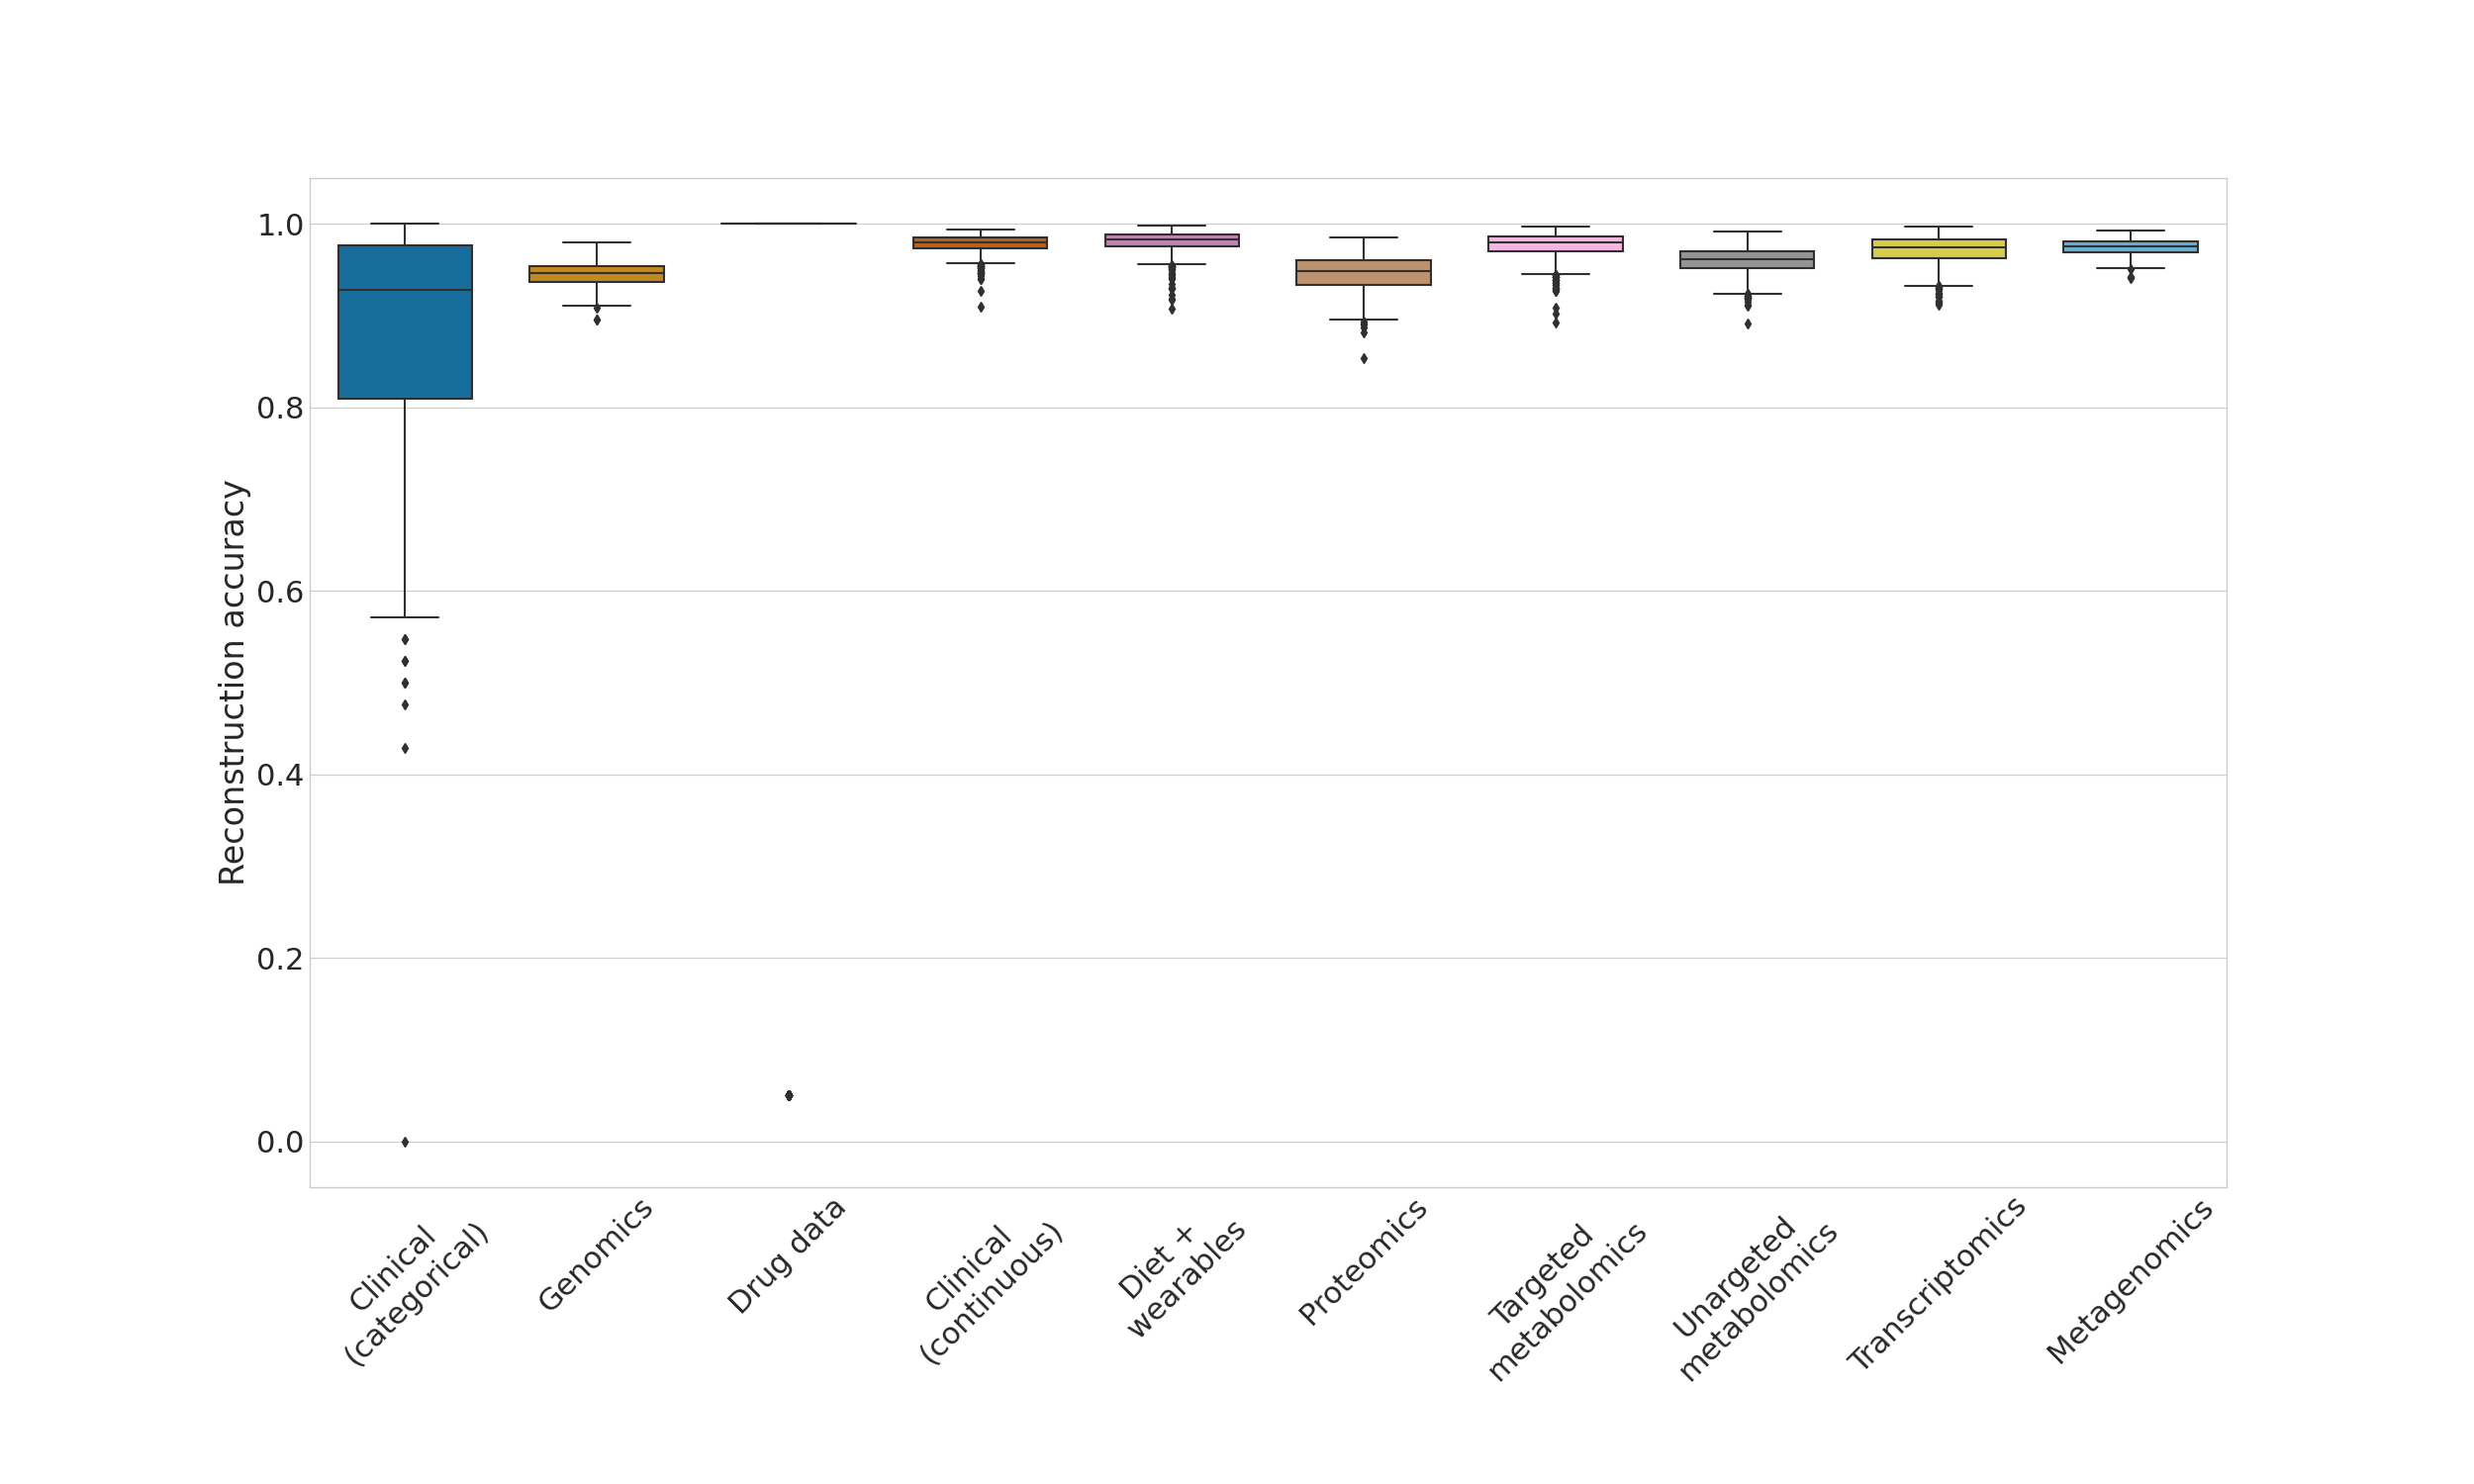

We can now plot the distributions of the features in the latent space in an UMAP embedding.  

In [20]:
#Todos: make folder creation as seperate function

def get_embedding(latent):
    results_folder = path + 'results/'
    isExist = os.path.exists(results_folder)
    if not isExist:
        os.makedirs(results_folder)

    # UMAP
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(latent)
    np.save(path + "results/embedding.npy", embedding)
    return(embedding)

embedding = get_embedding(latent)

/home/valentas/snap/jupyter/common/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:319: UserWarning: Could not obtain multiprocessing lock due to OS level error: [Errno 13] Permission denied
A likely cause of this problem is '/dev/shm' is missing orread-only such that necessary semaphores cannot be written.
*** The responsibility of ensuring multiprocessing safe access to this initialization sequence/module import is deferred to the user! ***

  warnings.warn(msg % str(e))


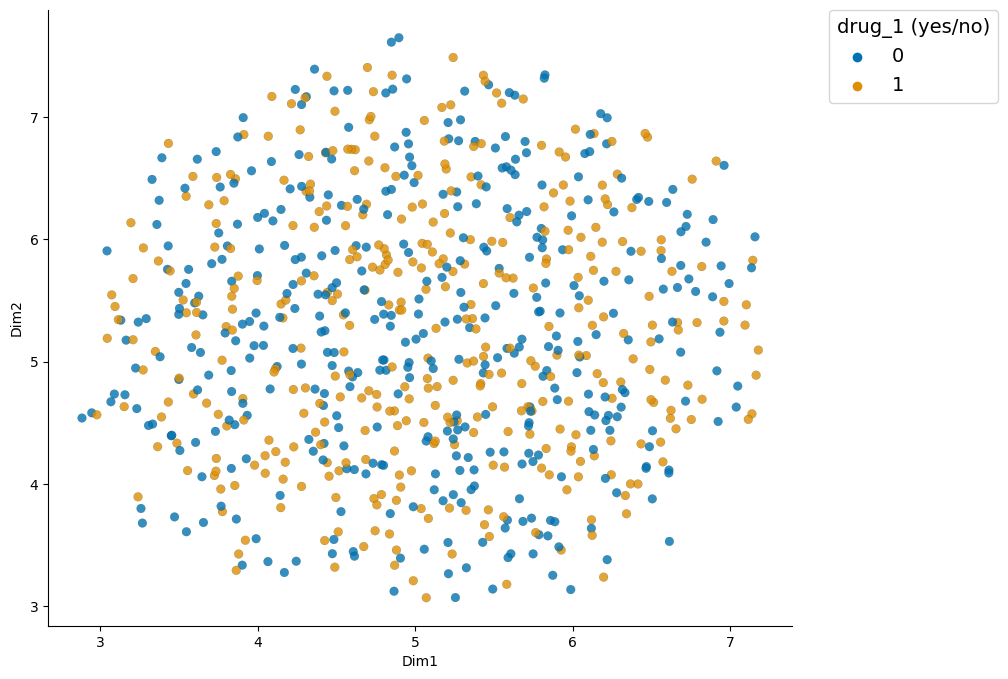

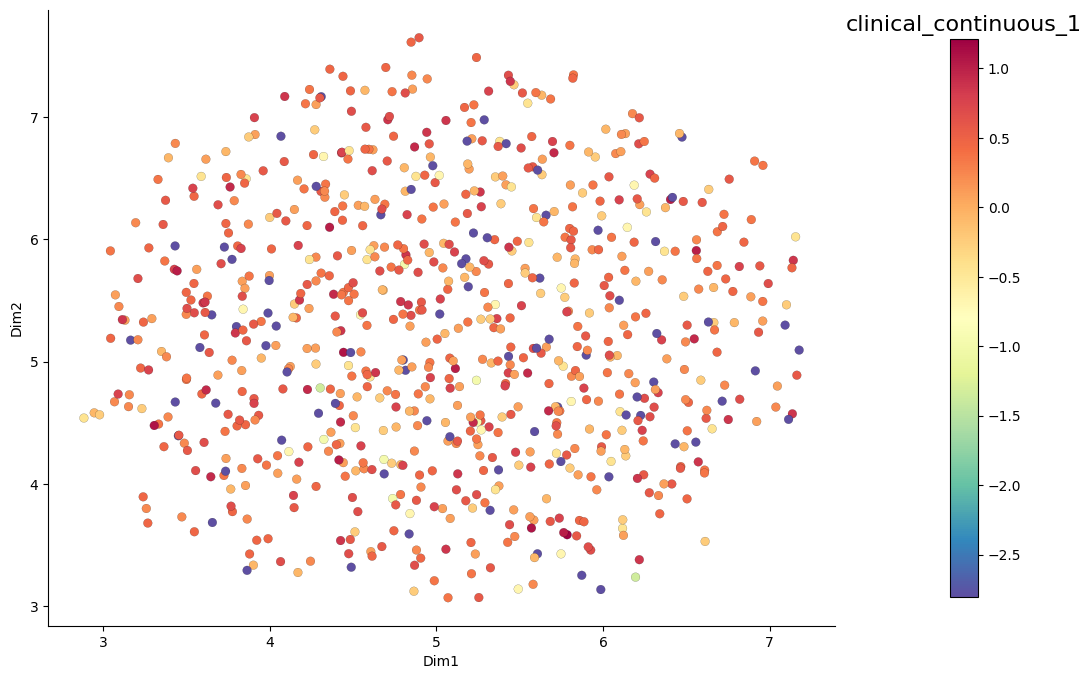

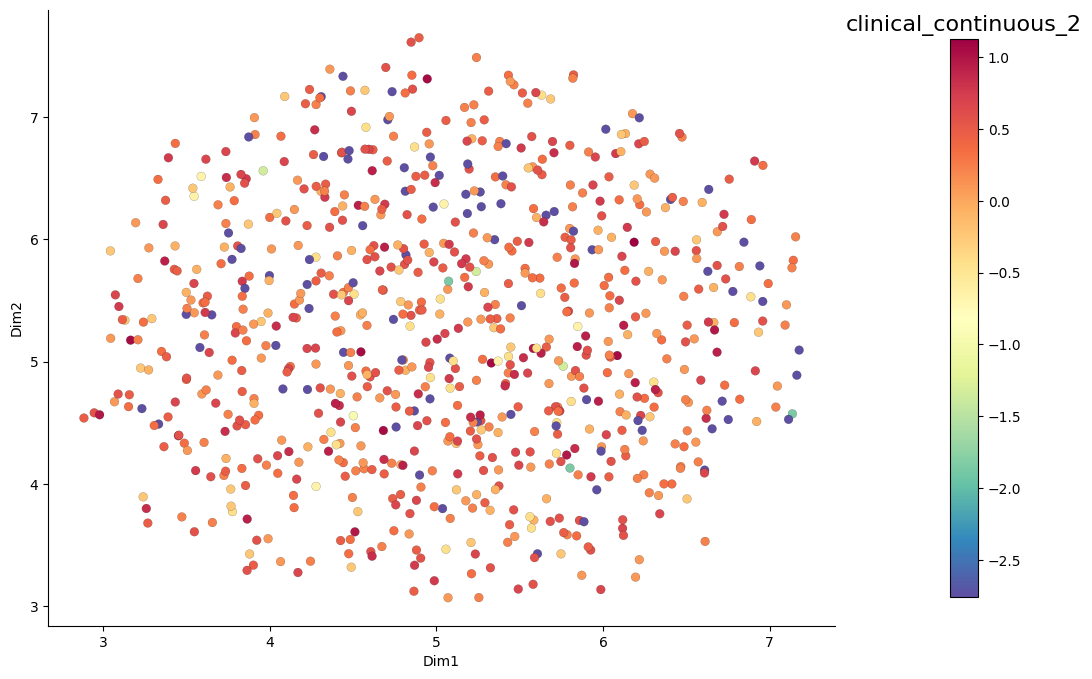

In [98]:
def get_feature_data(data_type, feature_of_interest, cat_list=cat_list, #TODO: negative values goes down to -2, while positive only until 1
                     con_list=con_list, cat_names=cat_names, con_names=con_names):
    
    if data_type=='categorical':
        cat_list_integer = [np.argmax(cat, axis=-1) for cat in cat_list]
        np_data_ints = np.concatenate(cat_list_integer, axis=-1)
        headers = cat_names
    elif data_type=='continuous':
        np_data_ints = np.concatenate(con_list, axis=-1)
        headers = con_names
    else:
        raise ValueError("Wrong data type was selected")
    
    feature_data = np_data_ints[:,list(headers).index(feature_of_interest)]
    
    return(feature_data, headers)
    

def visualize_embedding(data_type, feature_of_interest, embedding, cat_list=cat_list, 
                        con_list=con_list, cat_names=cat_names, con_names=con_names):
    
    feature_data, headers = get_feature_data(data_type, feature_of_interest, 
                                             cat_list=cat_list, con_list=con_list, 
                                             cat_names=cat_names, con_names=con_names)
    
    
    if data_type == 'categorical':
        embedding_plot_discrete(embedding, feature_data[mask], 
                                f"{feature_of_interest} (yes/no)", 
                                path + f"results/umap_{feature_of_interest}.png")
        
    elif data_type =='continuous':
        embedding_plot_float(embedding, feature_data[mask], feature_of_interest,
                             path + f"results/umap_{feature_of_interest}.png")
    

    
visualize_embedding('categorical', "drug_1", embedding)
visualize_embedding('continuous', "clinical_continuous_1", embedding)
visualize_embedding('continuous', "clinical_continuous_2", embedding)    
     
    

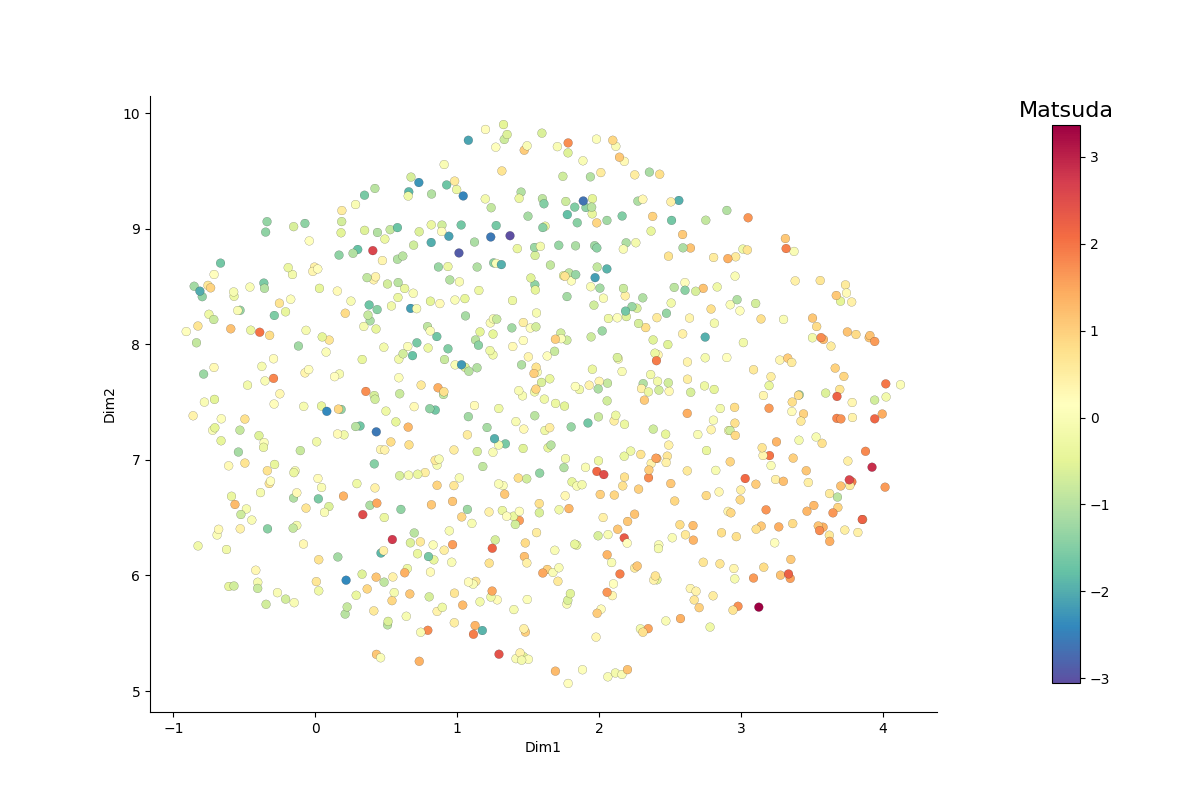

In [111]:
def get_pearsonr(data_type, feature_of_interest, embedding, cat_list=cat_list, 
                 con_list=con_list, cat_names=cat_names, con_names=con_names):
    
    feature_data, _ = get_feature_data(data_type, feature_of_interest, 
                                       cat_list, con_list, 
                                       cat_names, con_names)
    
    # Correlate embedding with variable 
    pearson_0dim = pearsonr(embedding[:,0], feature_data)
    pearson_1dim = pearsonr(embedding[:,1], feature_data)
    
    return(pearson_0dim, pearson_1dim)

    
get_pearsonr('categorical', "drug_1", embedding)
get_pearsonr('continuous', "clinical_continuous_1", embedding)


((-0.044465149592983276, 0.21216845812222104),
 (0.04363332689764882, 0.22085312917857028))

Feature importance inspired by SHAP by changing one variable at the time to missing and calculate change in the latent space. 

In [121]:

# Feature importance categorical

def get_feature_importance_categorical(model, train_loader, kld_w=1): #Which kld_w and train_loader # should not matter equal to 1

   all_diffs = []
   sum_diffs = []
   sum_diffs_abs = []
   total_diffs = []
   loss_cat = []
   pos = 0
   cat_in = train_loader.dataset.cat_all
   cat_shapes = train_loader.dataset.cat_shapes

   for cat_shape in cat_shapes:
      cat_dataset = cat_in[:, pos:(cat_shape[1]*cat_shape[2] + pos)]
      cat_dataset = np.array(cat_dataset.view(cat_in.shape[0], cat_shape[1], cat_shape[2]))
      for feature_index in tqdm(range(cat_shape[1])):

         new_cat = np.copy(cat_dataset)
         new_cat[:,feature_index,:] = 0
         new_cat = new_cat.reshape(new_cat.shape[0], -1)
         input_cat = np.copy(cat_in)
         input_cat[:, pos:(cat_shape[1]*cat_shape[2] + pos)] = new_cat
         input_cat = torch.from_numpy(input_cat)

         dataset = VAE_v2_1.Dataset(input_cat, train_loader.dataset.con_all, 
                                    train_loader.dataset.con_shapes, 
                                    train_loader.dataset.cat_shapes)

         new_loader = DataLoader(dataset, batch_size=1, 
                              drop_last=False, shuffle=False, 
                              pin_memory=train_loader.pin_memory) # removed num_workers=1,

         out = model.latent(new_loader, kld_w)

         new_latent_vector = out[0]
         diff = latent-new_latent_vector
         diff_abs = np.abs(latent-new_latent_vector)
         loss_cat.append(out[-1])
         all_diffs.append(diff)
         sum_diffs.append(np.sum(diff, axis = 1))
         sum_diffs_abs.append(np.sum(diff_abs, axis = 1))
         total_diffs.append(np.sum(diff))
         break #added

   all_diffs_cat_np = np.asarray(all_diffs)
   sum_diffs_cat_np = np.asarray(sum_diffs)
   sum_diffs_cat_abs_np = np.asarray(sum_diffs_abs)
   total_diffs_cat_np = np.asarray(total_diffs)
   return(all_diffs, all_diffs_cat_np, sum_diffs_cat_np, sum_diffs_cat_abs_np, total_diffs_cat_np)

all_diffs, all_diffs_cat_np, sum_diffs_cat_np, sum_diffs_cat_abs_np,\
        total_diffs_cat_np = get_feature_importance_categorical(best_model, train_loader)


  0%|          | 0/393 [00:15<?, ?it/s]


====> Test set loss: 12.4737


  0%|          | 0/20 [00:14<?, ?it/s]


====> Test set loss: 12.4081


  0%|          | 0/42 [00:16<?, ?it/s]

====> Test set loss: 12.5246


In [119]:
def get_feature_importance_continuous(model, train_loader, kld_w=1):
# Feature importance continuous

    all_diffs_con = []
    sum_diffs_con = []
    sum_diffs_con_abs = []
    total_diffs_con = []
    loss_con = []
    con_shape = train_loader.dataset.con_all.shape[1]
    for feature_index in tqdm(range(con_shape)):

        new_con = np.array(train_loader.dataset.con_all)
        new_con[:,feature_index] = 0
        new_con = torch.from_numpy(new_con)

        dataset = VAE_v2_1.Dataset(train_loader.dataset.cat_all, new_con,
                                   train_loader.dataset.con_shapes,
                                   train_loader.dataset.cat_shapes)

        new_loader = DataLoader(dataset, batch_size=len(mask), 
                              drop_last=False, shuffle=False, 
                              pin_memory=train_loader.pin_memory) #removed num_workers=1,

        out = model.latent(new_loader, kld_w)

        new_latent_vector = out[0]
        loss_con.append(out[-1])
        diff_abs = np.abs(latent-new_latent_vector)
        diff = latent-new_latent_vector
        all_diffs_con.append(diff)
        sum_diffs_con.append(np.sum(diff, axis = 1))
        sum_diffs_con_abs.append(np.sum(diff_abs, axis = 1))
        total_diffs_con.append(np.sum(diff))
        break #added

    all_diffs_con_np = np.asarray(all_diffs_con)
    sum_diffs_con_np = np.asarray(sum_diffs_con)
    sum_diffs_con_abs_np = np.asarray(sum_diffs_con_abs)
    total_diffs_con_np = np.asarray(total_diffs_con)
    return(all_diffs_con_np, sum_diffs_con_np, sum_diffs_con_abs_np, total_diffs_con_np)

all_diffs_con_np, sum_diffs_con_np, sum_diffs_con_abs_np,\
            total_diffs_con_np = get_feature_importance_continuous(best_model, train_loader)


  0%|          | 0/8052 [00:00<?, ?it/s]

====> Test set loss: 12.3876


In [123]:
# all_diffs, all_diffs_con, sum_diffs, sum_diffs_con, sum_diffs_abs, sum_diffs_con_abs, total_diffs, total_diffs_con

# def save_feat_results(all_diffs_cat_np, sum_diffs_cat_np, sum_diffs_cat_abs_np, total_diffs_cat_np, 
#                  all_diffs_con_np, sum_diffs_con_np, sum_diffs_con_abs_np, total_diffs_con_np):

def save_feat_results(all_diffs, sum_diffs, sum_diffs_abs, total_diffs, 
                 all_diffs_con, sum_diffs_con, sum_diffs_con_abs, total_diffs_con):
    
    # Save results
    all_diffs_both = np.concatenate((all_diffs, all_diffs_con), axis=0)
    sum_diffs_both = np.concatenate((sum_diffs, sum_diffs_con), axis=0)
    sum_diffs_both_abs = np.concatenate((sum_diffs_abs, sum_diffs_con_abs), axis=0)
    total_diffs_both = np.concatenate((total_diffs, total_diffs_con), axis=0)

    np.save(path + "results/all_SHAP_diffs.npy", all_diffs_both)
    np.save(path + "results/sum_diffs.npy", sum_diffs_both)
    np.save(path + "results/sum_diffs_abs.npy", sum_diffs_both_abs)
    np.save(path + "results/total_diffs_final.npy", total_diffs_both)

    
save_feat_results(all_diffs_cat_np, sum_diffs_cat_np, sum_diffs_cat_abs_np, total_diffs_cat_np, 
                 all_diffs_con_np, sum_diffs_con_np,sum_diffs_con_abs_np, total_diffs_con_np)


In [16]:
con_names, cat_names = get_data_headers(path)


NameError: name 'train_loader' is not defined

In [139]:
def f_plot_importance(path, sum_diffs, features, feature_names, fig_name):
    fig = plt.figure(figsize = (20,20))
    plot_importance.summary_plot(sum_diffs, features=features, 
                                 feature_names=feature_names, max_display = 25, 
                                 show = False, size = 30)
    plt.savefig(path + f"results/{fig_name}.png")

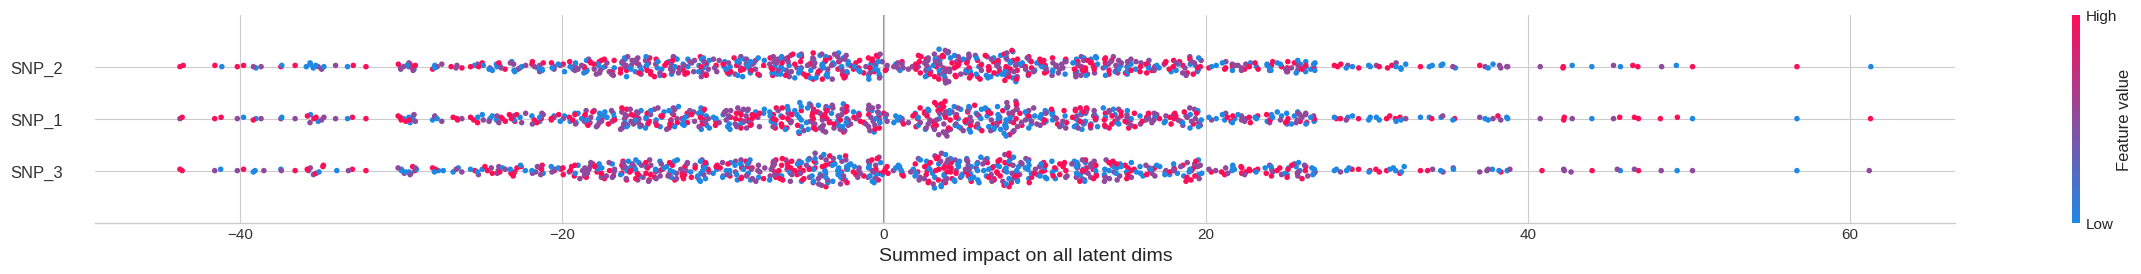

In [141]:
def plot_categorical_importance(path, sum_diffs, cat_list, feature_names, fig_name): #TODO: It is strangely the same plots for each SNP
    
    # Converting from one hot to numerical variables
    cat_ints_list = []
    for cat in cat_list:
        cat_target = np.argmax(cat, 2)
        cat_target[np.sum(cat, 2) == 0] = -1
        cat_ints_list.append(cat_target)
    
    cat_target_all = np.concatenate(cat_ints_list, axis=1)
    sum_diffs = np.transpose(sum_diffs)
    
    f_plot_importance(path=path,
                      sum_diffs=sum_diffs,
                      features=cat_target_all,
                      feature_names=cat_names,
                      fig_name='importance_SHAP_cat')

    
plot_categorical_importance(path=path,
                            sum_diffs=sum_diffs_cat_np,
                            cat_list=cat_list,
                            feature_names=cat_names,
                            fig_name='importance_SHAP_cat')

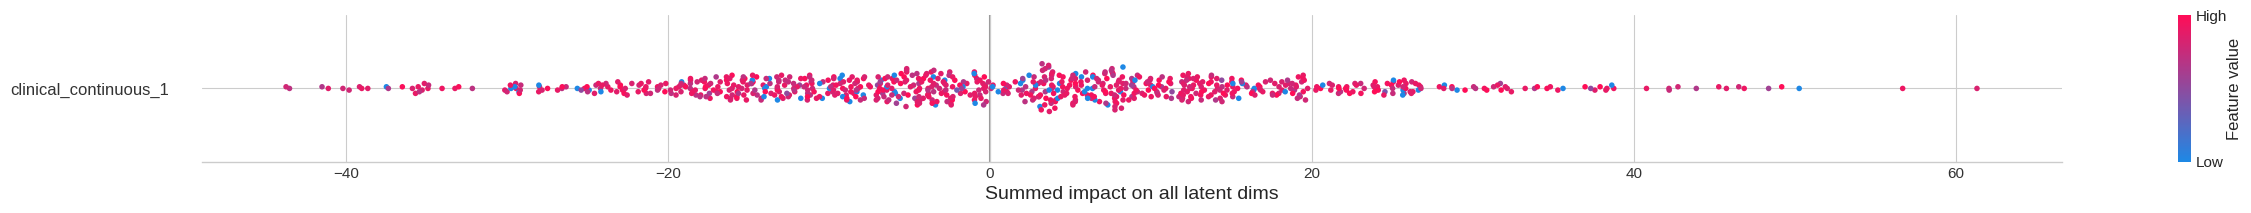

In [152]:
def plot_continuous_importance(path, train_loader, sum_diffs, feature_names, fig_name):
    
    con_all = np.asarray(train_loader.dataset.con_all)
    sum_diffs = np.transpose(sum_diffs)

    f_plot_importance(path=path,
                      sum_diffs=sum_diffs,
                      features=con_all,
                      feature_names=con_names,
                      fig_name='importance_SHAP_con')


plot_continuous_importance(path=path,
                           train_loader=train_loader,
                           sum_diffs=sum_diffs_con_np,
                           feature_names=con_names,
                           fig_name='importance_SHAP_c')

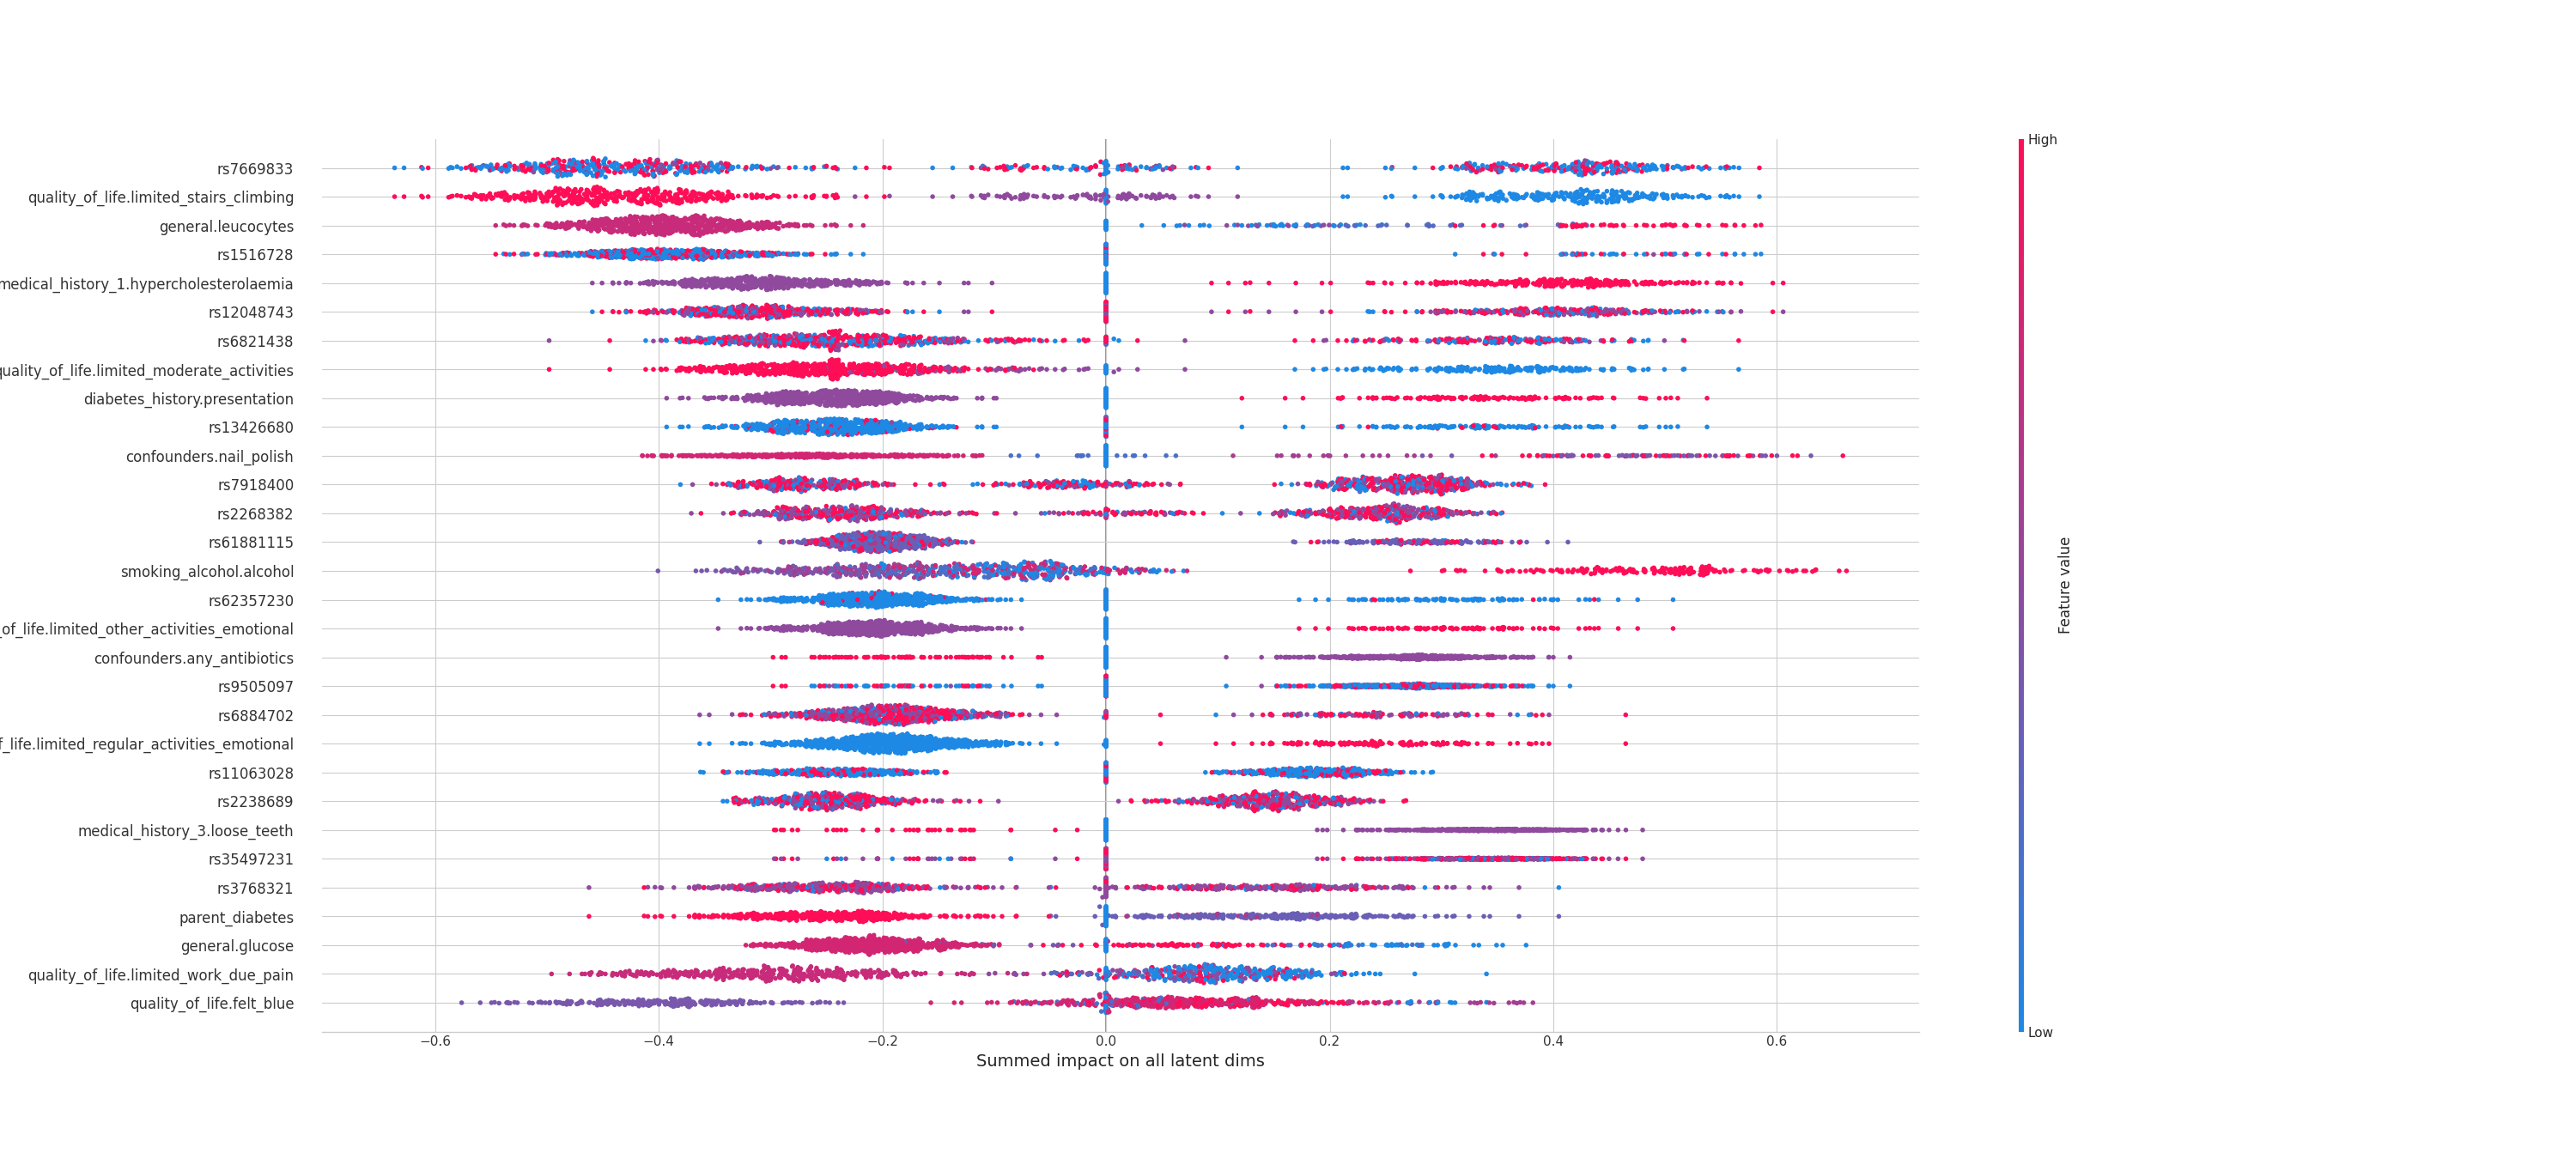

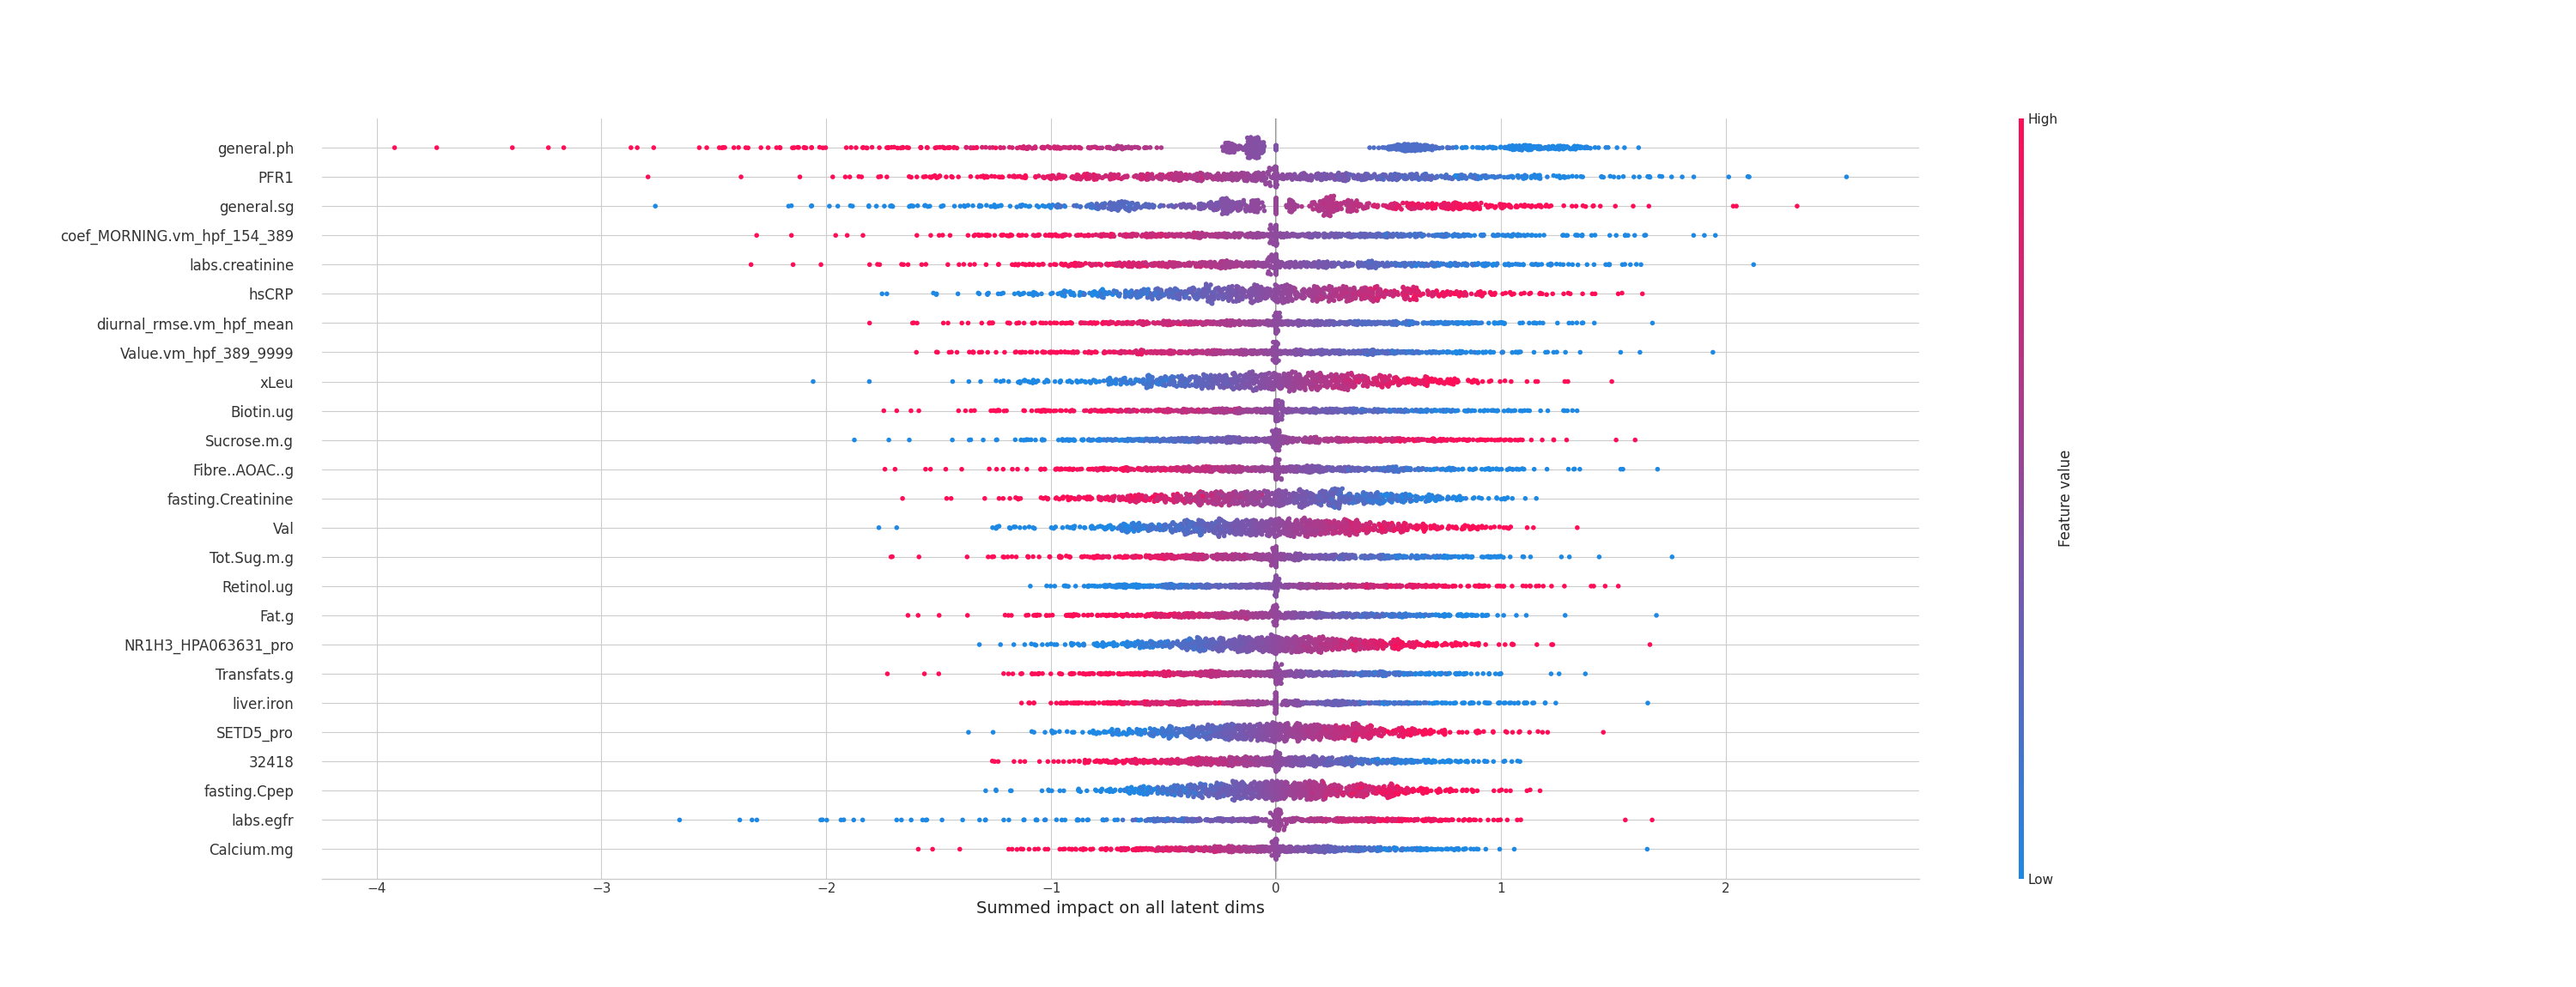

We also calculated the importance based on the weights from input to the first layer. This only represent the importance for defining the latent space (the encoder part). This was ony directy possible because our optimal setting only included one hidden layer. The categorical data is a sum of each input from the flatten one-hot encoding.

In [ ]:
def get_feat_importance_on_weights(model, train_loader, cat_shapes):
   #Based on weights

   # get weights
   w = np.array(model.encoderlayers[0].weight.data.to("cpu")) # TODOs: should it be trained or not trained model? -trained

   w_sum = np.sum(np.abs(w), axis=0)

   w_sum_con = w_sum[train_loader.dataset.cat_all.shape[1]:]
   w_sum_cat = w_sum[0:train_loader.dataset.cat_all.shape[1]]

   # Get the sum of each input for each categorical one-hot vector
   w_sum_cat_final = []
   pos = 0
   for s in cat_shapes:
      n = s[1] * s[2]
      print(n)
      cat_w_sum_tmp = w_sum_cat[pos:(n + pos)]
      cat_w_sum_tmp = cat_w_sum_tmp.reshape(s[1], s[2])
      sum_d = np.sum(cat_w_sum_tmp, axis=1)
      w_sum_cat_final.extend(sum_d)


   feature_order_cat = np.flip(np.argsort(w_sum_cat_final))
   features_w_cat = cat_names[feature_order_cat]
   # Save the 
   tmp_pd = pd.DataFrame(np.array(w_sum_cat_final)[feature_order_cat], index=features_w_cat)
   tmp_pd.T.to_csv(path + "results/importance_w_cat.txt")

   feature_order = np.flip(np.argsort(w_sum_con))
   features_w_con = con_names[feature_order]

   tmp_pd = pd.DataFrame(w_sum_con[feature_order], index=features_w_con)
   tmp_pd.T.to_csv(path + "results/importance_w_con.txt")


get_feat_importance_on_weights(model, train_loader, cat_shapes)

After this the <i>identify_drug_assosiation.ipynb</i> can be run for extracting assosiations learned by the networks